In [9]:
import os
import json
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("/netscratch2/jlautz/model_robustness/src/model_robustness/attacks/notebooks"), '..')))

from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)
np.random.seed(0)

from attacks.networks import ConvNetSmall
from advertorch.attacks import GradientSignAttack, LinfPGDAttack

device = "cpu"
ROOT = Path("")

In [44]:
results_path = os.path.join(ROOT, "/netscratch2/jlautz/model_robustness/src/model_robustness/plots/images_plots")

In [46]:
# CIFAR10
checkpoint_path = os.path.join(ROOT, "/netscratch2/dtaskiran/zoos/CIFAR10/small/tune_zoo_cifar10_small_hyperparameter_10_fixed_seeds")
data_path = os.path.join(ROOT, "/netscratch2/dtaskiran/zoos/CIFAR10/small/tune_zoo_cifar10_small_hyperparameter_10_fixed_seeds/dataset.pt")
data_root = os.path.join(ROOT, "/netscratch2/jlautz/model_robustness/src/model_robustness/data/CIFAR10")

In [11]:
# MNIST
checkpoint_path = os.path.join(ROOT, "/netscratch2/dtaskiran/zoos/MNIST/tune_zoo_mnist_hyperparameter_10_fixed_seeds")
data_path = os.path.join(ROOT, "/netscratch2/dtaskiran/zoos/MNIST/tune_zoo_mnist_hyperparameter_10_fixed_seeds/dataset.pt")
data_root = os.path.join(ROOT, "/netscratch2/jlautz/model_robustness/src/model_robustness/data/MNIST")

In [47]:
model_list_path = os.path.join(data_root, "PGD", "hyp-10-f")

In [48]:
dataset = torch.load(data_path)["testset"]

In [49]:
with open(os.path.join(model_list_path, 'model_list.txt'), "r") as items:
    model_paths = items.readlines()

    for i, l in enumerate(model_paths):
        model_paths[i] = l.replace("\n", "")

In [136]:
# Define subsets of testset used for each of the n_models models
generator = torch.Generator().manual_seed(0)
imgs_per_model = len(dataset) / 50
split = [int(imgs_per_model) for i in range(50)]
remainder = len(dataset) - sum(split)
split[-1] += remainder

subsets = random_split(dataset, split, generator=generator)

In [50]:
# subset = subsets[0]
aux_loader = DataLoader(dataset=dataset, batch_size=5, shuffle=False)
for cln_data, true_labels in aux_loader:
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


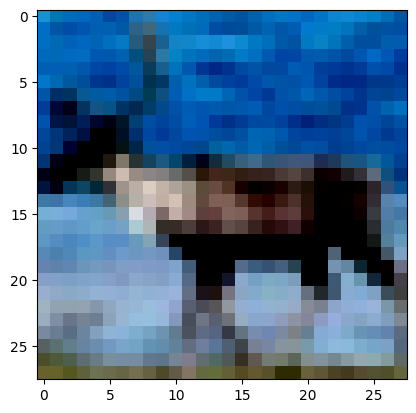

In [60]:
plt.imshow(cln_data[3].detach().cpu().numpy().transpose(1,2,0))

In [64]:
#plt.imshow(np.moveaxis(cln_data[4].detach().cpu().numpy(), 0, 2), cmap="r")

In [79]:
eps = [0.1, 0.2, 0.3, 0.4, 0.5]
images = torch.tensor((), device=device)
for e in eps:
    print(f"doing eps={e}")
    path = model_paths[0]
    model_config_path = os.path.join(checkpoint_path, path, "params.json")
    config_model = json.load(open(model_config_path,))
    
    model = ConvNetSmall(
        channels_in=config_model["model::channels_in"],
        nlin=config_model["model::nlin"],
        dropout=config_model["model::dropout"],
        init_type=config_model["model::init_type"]
    )
    
    try:
        model.load_state_dict(
            torch.load(os.path.join(checkpoint_path, path, "checkpoint_000050", "checkpoints"))
        )
    except RuntimeError:
        model = ConvNetSmall(
        channels_in=config_model["model::channels_in"],
        nlin=config_model["model::nlin"],
        dropout=0,
        init_type=config_model["model::init_type"]
        )
        model.load_state_dict(
            torch.load(os.path.join(checkpoint_path, path, "checkpoint_000050", "checkpoints"))
        )
    model.to(device)
    
    aux_loader = DataLoader(dataset=dataset, batch_size=5, shuffle=False)
    for cln_data, true_labels in aux_loader:
        break
    cln_data, true_labels = cln_data.to(device), true_labels.to(device)
    
#     adversary=GradientSignAttack(
#         model,
#         loss_fn=nn.CrossEntropyLoss(reduction="sum"),
#         eps=e,
#         nb_iter=10,
#         eps_iter=e/10.0,
#         rand_init=True,
#         clip_min=0.0,
#         clip_max=1.0,
#         targeted=False
#     )
    adversary=GradientSignAttack(
        model,
        loss_fn=nn.CrossEntropyLoss(reduction="sum"),
        eps=e,
        targeted=False
    )
    adv_images = adversary.perturb(cln_data, true_labels)
    
    images = torch.cat((images, adv_images))

doing eps=0.1
doing eps=0.2
doing eps=0.3
doing eps=0.4
doing eps=0.5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


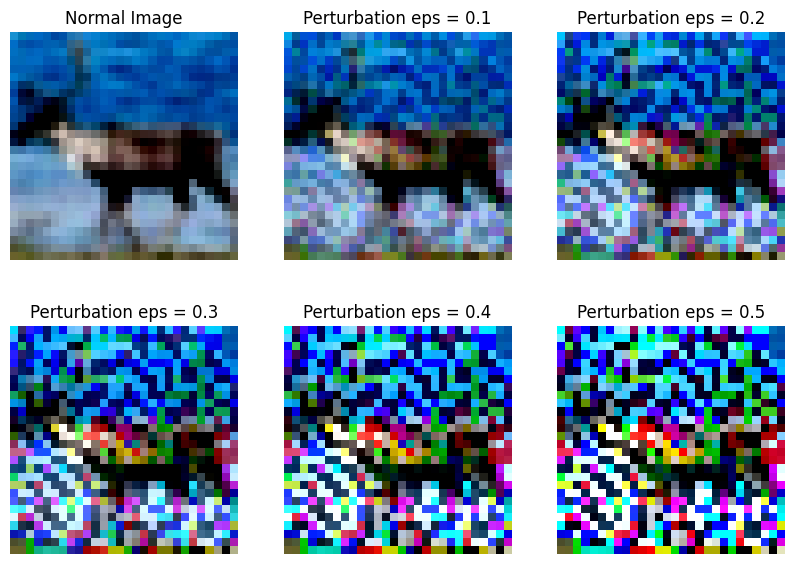

In [89]:
fig = plt.figure(figsize=(10,7))

rows = 2
cols = 3
img = 3

fig.add_subplot(rows, cols, 1)
plt.imshow(cln_data[img].detach().cpu().numpy().transpose(1,2,0))
#plt.imshow(np.moveaxis(cln_data[4].detach().cpu().numpy(), 0, 2), cmap="gray")
plt.axis('off')
plt.title("Normal Image")

for i in range(5):
    fig.add_subplot(rows, cols, i+1+1)
    
    plt.imshow(images[img + i*5].detach().cpu().numpy().transpose(1,2,0))
    # plt.imshow(np.moveaxis(images[i + (i+1)*4].detach().cpu().numpy(), 0, 2), cmap="gray")
    plt.axis('off')
    plt.title(f"Perturbation eps = {eps[i]}")
    
#plt.savefig(os.path.join(results_path, "MNIST_PGD_images.png"), bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(2, 2, subplot_kw=dict(projection="polar"))
axs[0, 0].plot(x, y)
axs[1, 1].scatter(x, y)


In [ ]:
for num in range(1, rows*columns+1):
    
    fig.add_subplot(rows, columns, num)
    
    idx = num - 1
    
    plt.imshow(img_arrs[idx], aspect='auto')
    plt.xlabel(f'{img_arrs[idx].shape}', fontsize=12)
    
    if num % 3 == 1 : #if remainder is 1
        file_idx = num // 3 # get quotient
        plt.ylabel(f'{sorted(os.listdir(origin_dir))[file_idx]}', 
                  rotation=0,
                  fontsize=12,
                  labelpad=50) #add space between ylabel and yaxis
    
    
fig.tight_layout() # used to adjust padding between subplots 

cols = ['origin', 'resized', 'gray']

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

In [142]:
images = torch.tensor((), device=device)
labels = torch.tensor((), device=device)

for i, path in enumerate(model_paths):
    model_config_path = os.path.join(checkpoint_path, path, "params.json")
    config_model = json.load(open(model_config_path,))

    model = ConvNetSmall(
        channels_in=config_model["model::channels_in"],
        nlin=config_model["model::nlin"],
        dropout=config_model["model::dropout"],
        init_type=config_model["model::init_type"]
    )
    
    try:
        model.load_state_dict(
            torch.load(os.path.join(checkpoint_path, path, "checkpoint_000050", "checkpoints"))
        )
    except RuntimeError:
        model = ConvNetSmall(
        channels_in=config_model["model::channels_in"],
        nlin=config_model["model::nlin"],
        dropout=0,
        init_type=config_model["model::init_type"]
        )
        model.load_state_dict(
            torch.load(os.path.join(checkpoint_path, path, "checkpoint_000050", "checkpoints"))
        )
    model.to(device)
        
    subset = subsets[i]
    aux_loader = DataLoader(dataset=subset, batch_size=len(subset), shuffle=False)
    for cln_data, true_labels in aux_loader:
        break
    cln_data, true_labels = cln_data.to(device), true_labels.to(device)
    # plt.imshow(np.moveaxis(cln_data[9].detach().cpu().numpy(), 0, 2))
    
    adversary=LinfPGDAttack(
        model,
        loss_fn=nn.CrossEntropyLoss(reduction="sum"),
        eps=1.0,
        nb_iter=3,
        eps_iter=2.0,
        rand_init=True,
        clip_min=0.0,
        clip_max=1.0,
        targeted=False
    )
    adv_images = adversary.perturb(cln_data, true_labels)

    images = torch.cat((images, adv_images))
    labels = torch.cat((labels, true_labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


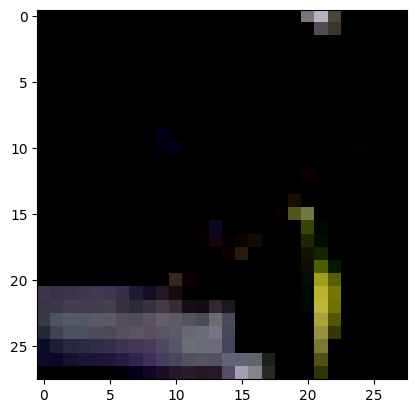

In [123]:
plt.imshow(np.moveaxis(adv_images[9].detach().cpu().numpy(), 0, 2))

In [143]:
perturbed_dataset = TensorDataset(images, labels)

In [144]:
loader = DataLoader(dataset=perturbed_dataset, batch_size=10, shuffle=False)

In [145]:
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# eps = 2
loss_avg, acc_avg, num_exp = 0, 0, 0
for j, data in enumerate(loader):
    
    model.eval()
    
    imgs, labels = data
    labels = labels.type(torch.LongTensor)
    imgs, labels = imgs.to(device), labels.to(device)
    n_b = labels.shape[0]
    
    outputs = model(imgs)
    loss = criterion(outputs, labels)
    
    acc = np.sum(np.equal(np.argmax(outputs.cpu().data.numpy(), axis=-1), labels.cpu().data.numpy()))
    
    loss_avg += loss.item()
    acc_avg += acc
    num_exp += n_b
    
loss_avg /= num_exp
acc_avg /= num_exp
print(loss_avg, acc_avg)

In [35]:
# eps = 4
loss_avg, acc_avg, num_exp = 0, 0, 0
for j, data in enumerate(loader):
    
    model.eval()
    
    imgs, labels = data
    labels = labels.type(torch.LongTensor)
    imgs, labels = imgs.to(device), labels.to(device)
    n_b = labels.shape[0]
    
    outputs = model(imgs)
    loss = criterion(outputs, labels)
    
    acc = np.sum(np.equal(np.argmax(outputs.cpu().data.numpy(), axis=-1), labels.cpu().data.numpy()))
    
    loss_avg += loss.item()
    acc_avg += acc
    num_exp += n_b
    
loss_avg /= num_exp
acc_avg /= num_exp
print(loss_avg, acc_avg)

0.43337408335208893 0.1781


In [45]:
# eps=8
loss_avg, acc_avg, num_exp = 0, 0, 0
for j, data in enumerate(loader):
    
    model.eval()
    
    imgs, labels = data
    labels = labels.type(torch.LongTensor)
    imgs, labels = imgs.to(device), labels.to(device)
    n_b = labels.shape[0]
    
    outputs = model(imgs)
    loss = criterion(outputs, labels)
    
    acc = np.sum(np.equal(np.argmax(outputs.cpu().data.numpy(), axis=-1), labels.cpu().data.numpy()))
    
    loss_avg += loss.item()
    acc_avg += acc
    num_exp += n_b
    
loss_avg /= num_exp
acc_avg /= num_exp
print(loss_avg, acc_avg)

0.4284177385210991 0.177


In [61]:
loss_avg, acc_avg, num_exp = 0, 0, 0
for j, data in enumerate(loader):
    
    model.eval()
    
    imgs, labels = data
    labels = labels.type(torch.LongTensor)
    imgs, labels = imgs.to(device), labels.to(device)
    n_b = labels.shape[0]
    
    outputs = model(imgs)
    loss = criterion(outputs, labels)
    
    acc = np.sum(np.equal(np.argmax(outputs.cpu().data.numpy(), axis=-1), labels.cpu().data.numpy()))
    
    loss_avg += loss.item()
    acc_avg += acc
    num_exp += n_b
    
loss_avg /= num_exp
acc_avg /= num_exp
print(loss_avg, acc_avg)

0.42977814666032793 0.178


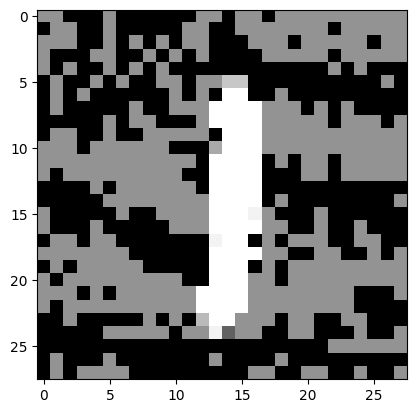

In [62]:
plt.imshow(np.moveaxis(perturbed_dataset[0][0].detach().cpu().numpy(), 0, 2), cmap="gray")

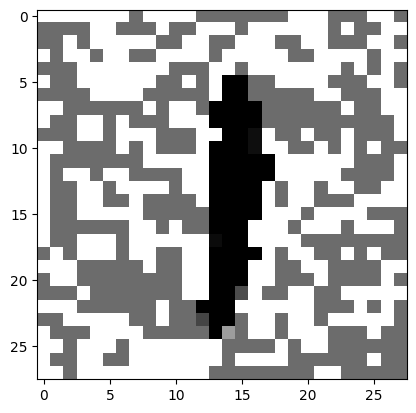

In [19]:
plt.imshow(np.moveaxis(perturbed_dataset2[0][0].detach().cpu().numpy(), 0, 2), cmap="gray_r")

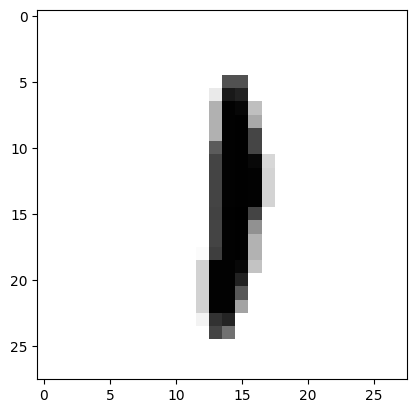

In [80]:
plt.imshow(np.moveaxis(dataset[0][0].detach().cpu().numpy(), 0, 2), cmap="gray_r")